In [ ]:
!pip install pandas
!pip install requests
!pip install tqdm
!pip install librosa
!pip install matplotlib
!pip install transformers sentencepiece accelerate
!pip install datasets

^C


In [ ]:
import os
import re
import subprocess
import json
import random
import tarfile
import threading
from concurrent.futures import ThreadPoolExecutor

from pathlib import Path
from glob import glob

# Colab / A100 окружение
os.environ.setdefault("TOKENIZERS_PARALLELISM", "true")
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

import requests
import pandas as pd
import numpy as np
import soundfile as sf
import librosa
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from transformers import (
    AutoProcessor,
    WhisperForConditionalGeneration,
)


In [ ]:
import gdown

# --- test_data.tar ---
url_test = "https://drive.google.com/uc?id=1Nt0-ZD-tPuzL7uA95odienb50Spvlanl"
output_test = "test_data.tar"
gdown.download(url_test, output_test, quiet=False)

# --- train_data.tar ---
url_train = "https://drive.google.com/uc?id=10iFjn0-kvhCFkf8WEK-moGIEvgxIX3Ls"
output_train = "train_data.tar"
gdown.download(url_train, output_train, quiet=False)

# Проверяем, что всё скачалось
!ls -lh *.tar

Downloading...
From (original): https://drive.google.com/uc?id=1Nt0-ZD-tPuzL7uA95odienb50Spvlanl
From (redirected): https://drive.google.com/uc?id=1Nt0-ZD-tPuzL7uA95odienb50Spvlanl&confirm=t&uuid=f25de562-ae3e-42d5-a1c2-c83f76fb2fd6
To: /content/test_data.tar
100%|██████████| 741M/741M [00:15<00:00, 48.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=10iFjn0-kvhCFkf8WEK-moGIEvgxIX3Ls
From (redirected): https://drive.google.com/uc?id=10iFjn0-kvhCFkf8WEK-moGIEvgxIX3Ls&confirm=t&uuid=c7e97f7a-963c-4b69-b867-7cd7c286df7c
To: /content/train_data.tar
100%|██████████| 2.47G/2.47G [00:53<00:00, 46.3MB/s]


-rw-r--r-- 1 root root 707M Oct 16 11:21 test_data.tar
-rw-r--r-- 1 root root 2.4G Oct 16 11:28 train_data.tar


In [ ]:
# Распаковка
subprocess.run(["tar", "xf", "/content/train_data.tar"], check=True)
subprocess.run(["tar", "xf", "/content/test_data.tar"], check=True)
print("Готово.")

Готово.


In [ ]:
def _pick_existing(*candidates):
    for p in candidates:
        p = Path(p)
        if (p / "audio").exists():
            return p
    return None

train_dir = _pick_existing("data/train_data", "data/train_opus", "/content/train_opus")
test_dir  = _pick_existing("data/test_data",  "data/test_opus", "/content/test_opus")

if train_dir is None or test_dir is None:
    raise RuntimeError(
        "Не найдены папки с данными. Ожидались train_data/ или train_opus/ (и аналогично для test_*/)."
    )

print(f"train_dir: {train_dir.resolve()}")
print(f"test_dir : {test_dir.resolve()}")

# Списки файлов
train_files = glob(str(train_dir / "audio" / "*.opus"))
test_files  = glob(str(test_dir  / "audio" / "*.opus"))

print(f"Количество тренировочных файлов: {len(train_files)}")
print(f"Количество тестовых файлов: {len(test_files)}")

# Загрузка разметки
wb_path = train_dir / "word_bounds.json"
if not wb_path.exists():
    raise FileNotFoundError(f"Не найден файл разметки: {wb_path}")

with open(wb_path, "r", encoding="utf-8") as f:
    word_bounds = json.load(f)

print(f"Количество размеченных файлов (по ключам в word_bounds.json): {len(word_bounds)}")

# Базовые счётчики
train_ids = {Path(p).stem for p in train_files}
test_ids  = {Path(p).stem for p in test_files}
pos_ids   = set(word_bounds.keys())

# Положительные — это пересечение ключей разметки с фактически существующими файлами
pos_in_train = pos_ids & train_ids
pos_count    = len(pos_in_train)
neg_count    = len(train_files) - pos_count

print("\nРаспределение классов в train (по наличию id в word_bounds.json):")
print(f"Положительные примеры: {pos_count} ({pos_count / max(len(train_files),1) * 100:.1f}%)")
print(f"Отрицательные примеры: {neg_count} ({neg_count / max(len(train_files),1) * 100:.1f}%)")

# Полезные sanity-check'и
missing_annot_ids = pos_ids - train_ids
if missing_annot_ids:
    print(f"\nПредупреждение: в разметке есть {len(missing_annot_ids)} id, "
          f"для которых не найден файл в {train_dir/'audio'} (первые 5): "
          f"{sorted(list(missing_annot_ids))[:5]}")

test_leak_ids = pos_ids & test_ids
if test_leak_ids:
    print(f"\nПредупреждение: обнаружены {len(test_leak_ids)} id из теста, присутствующие в word_bounds.json "
          f"(первые 5): {sorted(list(test_leak_ids))[:5]}")

# Дубликаты по stem (на всякий случай)
def _dup_stems(paths):
    stems = [Path(p).stem for p in paths]
    seen, dup = set(), set()
    for s in stems:
        if s in seen:
            dup.add(s)
        else:
            seen.add(s)
    return dup

dup_train = _dup_stems(train_files)
dup_test  = _dup_stems(test_files)
if dup_train:
    print(f"\nПредупреждение: дубликаты id в train: {len(dup_train)} (первые 5): {sorted(list(dup_train))[:5]}")
if dup_test:
    print(f"\nПредупреждение: дубликаты id в test: {len(dup_test)} (первые 5): {sorted(list(dup_test))[:5]}")

# Небольшое превью
def _preview(ids_set, n=5):
    ids_list = sorted(list(ids_set))
    random.seed(0)
    return sorted(random.sample(ids_list, min(n, len(ids_list))))

print("\nПримеры id из train:", _preview(train_ids, 5))
print("Примеры id из test :", _preview(test_ids, 5))
print("Примеры POS id     :", _preview(pos_in_train, 5))


train_dir: /content/train_opus
test_dir : /content/test_opus
Количество тренировочных файлов: 87036
Количество тестовых файлов: 27000
Количество размеченных файлов (по ключам в word_bounds.json): 45000

Распределение классов в train (по наличию id в word_bounds.json):
Положительные примеры: 43536 (50.0%)
Отрицательные примеры: 43500 (50.0%)

Предупреждение: в разметке есть 1464 id, для которых не найден файл в /content/train_opus/audio (первые 5): ['0003794559365649378748674207742653051093', '0011205288540821388769694733881971472662', '0017555071741512486733044378842375662834', '0034279512091967040766062725376748798555', '0035290733401403665911383394105872976215']

Примеры id из train: ['0597603434123775859314835075295781679121', '3887644335431447736568685192231067173007', '5792726579846396104369023829983028836705', '6328643399491300512904300264239431487085', '7695466291673616000374612678783629562466']
Примеры id из test : ['0499438862317083278182675188266545621622', '31618090590754564

Пример положительного файла:


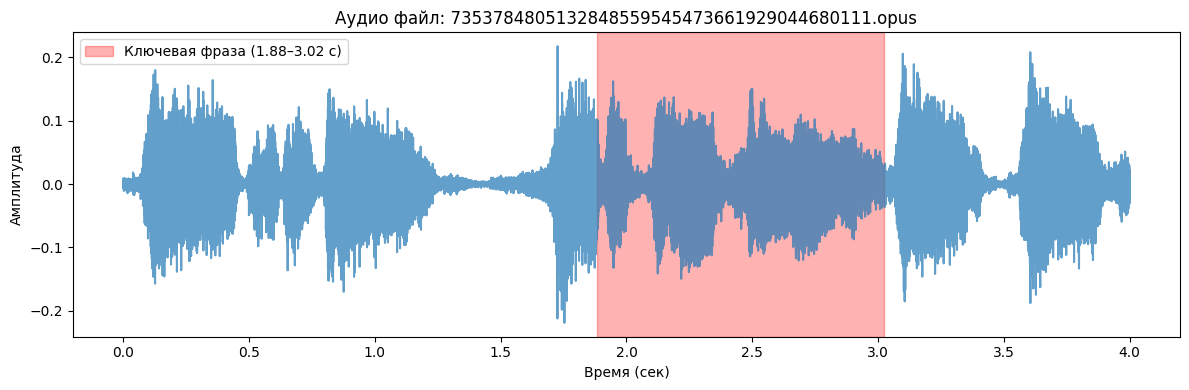

Прослушать 7353784805132848559545473661929044680111.opus (длина 4.00 с, sr=16000)



Пример отрицательного файла:


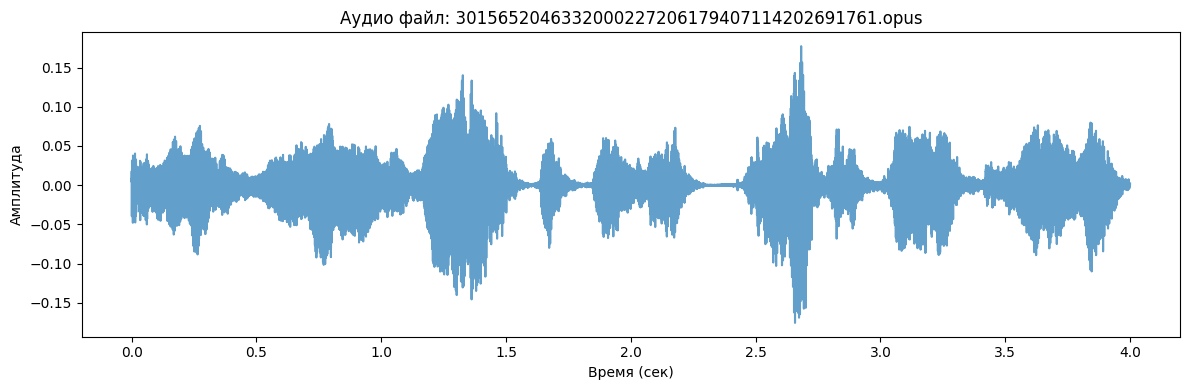

Прослушать 3015652046332000227206179407114202691761.opus (длина 4.00 с, sr=16000)


In [ ]:
def safe_load_audio(path, sr_target=16000):
    """
    Безопасно загружаем аудио. Пытаемся использовать librosa,
    при неудаче fallback на soundfile.
    """
    try:
        audio, sr = librosa.load(path, sr=sr_target)
    except Exception:
        data, sr = sf.read(path, dtype="float32", always_2d=False)
        if sr != sr_target:
            audio = librosa.resample(data, orig_sr=sr, target_sr=sr_target)
            sr = sr_target
        else:
            audio = data
    return audio, sr


def plot_audio_sample(file_path, word_bounds=None, sr_target=16000, play=True):
    """
    Визуализируем и при необходимости воспроизводим аудиофайл.

    Args:
        file_path: путь к аудио (str | Path)
        word_bounds: словарь {id: [start, end]} с разметкой
        sr_target: частота дискретизации для загрузки
        play: если True — воспроизводит аудио
    """
    file_path = Path(file_path)
    file_id = file_path.stem

    try:
        audio, sr = safe_load_audio(file_path, sr_target)
    except Exception as e:
        print(f"Не удалось загрузить {file_path.name}: {e}")
        return None, None

    duration = len(audio) / sr

    # Визуализация
    plt.figure(figsize=(12, 4))
    time = np.linspace(0, duration, len(audio))
    plt.plot(time, audio, alpha=0.7)
    plt.title(f"Аудио файл: {file_path.name}")
    plt.xlabel("Время (сек)")
    plt.ylabel("Амплитуда")

    # Подсветка сегмента с ключевым словом
    if word_bounds and file_id in word_bounds:
        start, end = word_bounds[file_id]
        plt.axvspan(start, end, alpha=0.3, color="red",
                    label=f"Ключевая фраза ({start:.2f}–{end:.2f} с)")
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Прослушивание
    if play:
        print(f"Прослушать {file_path.name} (длина {duration:.2f} с, sr={sr})")
        display(Audio(audio, rate=sr))

    return audio, sr


# Примеры положительных и отрицательных файлов
print("Пример положительного файла:")
pos_files = [f for f in train_files if Path(f).stem in word_bounds]
if pos_files:
    plot_audio_sample(pos_files[0], word_bounds)

print("\nПример отрицательного файла:")
neg_files = [f for f in train_files if Path(f).stem not in word_bounds]
if neg_files:
    plot_audio_sample(neg_files[0])


In [ ]:
# Устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Оптимизации CUDA / A100
if device.type == "cuda":
    try:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.set_float32_matmul_precision("high")
        torch.backends.cudnn.benchmark = True
        # SDPA (Scaled Dot-Product Attention)
        torch.backends.cuda.enable_flash_sdp(True)
        torch.backends.cuda.enable_mem_efficient_sdp(True)
        torch.backends.cuda.enable_math_sdp(False)
    except Exception:
        pass

# Находим тестовые файлы (.opus) — используем ранее найденный test_dir
if "test_dir" not in globals() or test_dir is None:
    raise RuntimeError("Переменная test_dir не определена. Выполните ячейку с определением train_dir/test_dir.")

TEST_DIR = test_dir
TEST_FILES = sorted(glob(str(TEST_DIR / "audio" / "*.opus")))
print(f"Найдено тестовых файлов: {len(TEST_FILES)}")


device: cuda
Найдено тестовых файлов: 27000


In [ ]:
# Константы и списки моделей
TARGET_SR = 16000
MAX_SAMPLES = 20 * TARGET_SR

# Whisper ASR конфигурация
WHISPER_MODEL_ID = "openai/whisper-large-v3"
WHISPER_LANGUAGE = "ru"
WHISPER_TASK = "transcribe"
WHISPER_MAX_NEW_TOKENS = 256


In [ ]:
# Аудио-утилита и инференс с чанкированием (Whisper)

def load_audio_opus_16k(path: str) -> np.ndarray:
    try:
        data, sr = librosa.load(path, sr=TARGET_SR)
    except Exception:
        data, sr = sf.read(path, dtype="float32", always_2d=False)
        if data.ndim == 2:
            data = data.mean(axis=1)
        if sr != TARGET_SR:
            try:
                data = librosa.resample(data, orig_sr=sr, target_sr=TARGET_SR)
            except Exception:
                x_old = np.linspace(0, 1, num=len(data), endpoint=False)
                x_new = np.linspace(0, 1, num=int(len(data) * TARGET_SR / sr), endpoint=False)
                data = np.interp(x_new, x_old, data).astype(np.float32)
    return data.astype(np.float32)


def load_waves_concurrent(paths, max_workers=None):
    if max_workers is None:
        # A100: много ядер CPU, но ограничим, чтобы не душить I/O
        try:
            import multiprocessing as mp
            cpu = mp.cpu_count()
        except Exception:
            cpu = 8
        max_workers = min(16, max(4, cpu // 2))
    def _safe(p):
        try:
            return load_audio_opus_16k(str(p))
        except Exception:
            return np.zeros(1, dtype=np.float32)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        return list(ex.map(_safe, paths))


def normalize_text(s: str) -> str:
    return re.sub(r"\s+", " ", s.lower().replace("ё", "е")).strip()


def contains_trigger(s: str) -> bool:
    t = normalize_text(s)
    patterns = [
        r"\bне[-\s]*слыш[ую]\b",
        r"\bне[-\s]*слышн[о0]\b",
    ]
    for p in patterns:
        if re.search(p, t):
            return True
    return False


@torch.no_grad()
def transcribe_batch_chunked(wave_list, processor, model, exec_device):
    forced_ids = processor.get_decoder_prompt_ids(language=WHISPER_LANGUAGE, task=WHISPER_TASK)

    def _generate_with_conf(input_features):
        gen = model.generate(
            input_features,
            forced_decoder_ids=forced_ids,
            max_new_tokens=WHISPER_MAX_NEW_TOKENS,
            return_dict_in_generate=True,
            output_scores=True,
        )
        sequences = gen.sequences  # [B, L]
        texts = processor.batch_decode(sequences, skip_special_tokens=True)
        # Подсчёт суммы лог-вероятностей предсказанных токенов и их количества
        if hasattr(gen, "scores") and gen.scores:
            gen_len = len(gen.scores)
            idx_start = sequences.shape[1] - gen_len
            next_tokens = sequences[:, idx_start:]
            sum_logprob = torch.zeros(sequences.size(0), device=sequences.device)
            for step_i, step_scores in enumerate(gen.scores):
                logp = torch.log_softmax(step_scores, dim=-1)
                tok_ids = next_tokens[:, step_i]
                tok_logp = logp.gather(1, tok_ids.unsqueeze(1)).squeeze(1)
                sum_logprob += tok_logp
            num_tokens = torch.full_like(sum_logprob, fill_value=gen_len)
            avg_logprob = sum_logprob / torch.clamp(num_tokens, min=1)
            conf = avg_logprob.exp()  # геометрическое среднее вероятностей
        else:
            conf = torch.zeros(sequences.size(0), device=sequences.device)
        return texts, conf.detach().float().cpu().numpy(), sequences

    texts_out = [None] * len(wave_list)
    conf_out = [0.0] * len(wave_list)

    # Обработка длинных файлов чанками (агрегируем лог-вероятности)
    for idx, w in enumerate(wave_list):
        if len(w) > MAX_SAMPLES:
            agg_sum_logprob = 0.0
            agg_tokens = 0
            chunk_texts = []
            for start in range(0, len(w), MAX_SAMPLES):
                chunk = w[start:start + MAX_SAMPLES]
                inputs = processor(chunk, sampling_rate=TARGET_SR, return_tensors="pt")
                input_features = inputs.input_features.to(exec_device)
                with torch.autocast(device_type=("cuda" if "cuda" in str(exec_device) else "cpu"), dtype=torch.float16, enabled=("cuda" in str(exec_device))):
                    texts_piece, conf_piece, sequences = _generate_with_conf(input_features)
                chunk_texts.append(texts_piece[0])
                # Восстанавливаем сумму лог-вероятностей по чанку из conf_piece и длины последовательности
                # conf_piece = exp(avg_logprob) => avg_logprob = log(conf_piece)
                # num_tokens равен количеству шагов генерации = sequences.shape[1] - (L - len(scores))
                # Здесь у нас batch=1, а len(scores) = sequences.shape[1] - idx_start
                # Мы уже использовали len(scores) внутри _generate_with_conf, но conf_piece — среднее;
                # приблизим агрегацию равномерным весом по числу токенов, оценим его как длину sequences хвоста
                # Для стабильности возьмём -log(conf_piece) * T как сумму отрицательных лог-вероятностей.
                # У нас нет прямого T здесь, поэтому используем эвристику: T = max(1, sequences.shape[1] - 1)
                T = max(1, sequences.shape[1] - 1)
                agg_sum_logprob += float(np.log(max(conf_piece[0], 1e-12)) * T)
                agg_tokens += T
            texts_out[idx] = " ".join(chunk_texts)
            conf_out[idx] = float(np.exp(agg_sum_logprob / max(1, agg_tokens)))

    # Пакетная обработка коротких файлов
    short_indices = [i for i, w in enumerate(wave_list) if len(w) <= MAX_SAMPLES]
    if short_indices:
        short_waves = [wave_list[i] for i in short_indices]
        inputs = processor(short_waves, sampling_rate=TARGET_SR, return_tensors="pt", padding=True)
        input_features = inputs.input_features.to(exec_device)
        with torch.autocast(device_type=("cuda" if "cuda" in str(exec_device) else "cpu"), dtype=torch.float16, enabled=("cuda" in str(exec_device))):
            texts, confs, _ = _generate_with_conf(input_features)
        for out_i, t, c in zip(short_indices, texts, confs):
            texts_out[out_i] = t
            conf_out[out_i] = float(c)

    texts_out = [t.strip().lower() if isinstance(t, str) else "" for t in texts_out]
    return texts_out, conf_out


In [ ]:
# Построение id -> путь к аудио (с извлечением недостающих из tar)
AUDIO_DIR_CANDIDATES = [Path("data/test_opus/audio"), Path("test_opus/audio")]
TAR_CANDIDATES = [Path("data/test_data.tar"), Path("test_data.tar")]

sample_df_all = pd.read_csv("/content/sample_submission.csv", dtype={"id": str})
sample_ids = sample_df_all["id"].astype(str).tolist()


def resolve_existing_audio_path(file_id: str) -> Path | None:
    for d in AUDIO_DIR_CANDIDATES:
        p = d / f"{file_id}.opus"
        if p.exists():
            return p
    return None


def ensure_target_audio_dir() -> Path:
    target = AUDIO_DIR_CANDIDATES[0]
    target.mkdir(parents=True, exist_ok=True)
    return target


def extract_missing_from_tar(ids: list[str]) -> dict[str, Path]:
    missing = set(ids)
    found: dict[str, Path] = {}
    target_dir = ensure_target_audio_dir()

    for tar_path in TAR_CANDIDATES:
        if not tar_path.exists():
            continue
        with tarfile.open(tar_path, "r:*") as tar:
            for member in tar:
                if not member.isfile() or not member.name.endswith('.opus'):
                    continue
                fid = Path(member.name).stem
                if fid not in missing:
                    continue
                fobj = tar.extractfile(member)
                if fobj is None:
                    continue
                dest_path = target_dir / f"{fid}.opus"
                with open(dest_path, "wb") as out_f:
                    out_f.write(fobj.read())
                found[fid] = dest_path
                missing.discard(fid)
        if not missing:
            break
    return found

# Строим маппинг id -> путь
id_to_path: dict[str, Path] = {}
for fid in sample_ids:
    p = resolve_existing_audio_path(fid)
    if p is not None:
        id_to_path[fid] = p

missing_ids = [fid for fid in sample_ids if fid not in id_to_path]
if missing_ids:
    extracted = extract_missing_from_tar(missing_ids)
    id_to_path.update(extracted)
    missing_ids = [fid for fid in sample_ids if fid not in id_to_path]

print(f"Доступно аудио для: {len(id_to_path)}/{len(sample_ids)}")


Доступно аудио для: 27000/27000


In [ ]:
# Инференс Whisper ASR: openai/whisper-large-v3
print(f"\n=== Whisper ASR: {WHISPER_MODEL_ID} ===")
submission_name = "submission__openai__whisper-large-v3.csv"
predict_proba_name = "predict_proba__openai__whisper-large-v3.csv"
if os.path.exists(submission_name) and os.path.exists(predict_proba_name):
    print(f"Пропускаем {WHISPER_MODEL_ID}: найдены существующие файлы {submission_name} и {predict_proba_name}")
else:
    processor = AutoProcessor.from_pretrained(WHISPER_MODEL_ID)

    multi_gpu = torch.cuda.is_available() and torch.cuda.device_count() > 1
    if multi_gpu:
        model = WhisperForConditionalGeneration.from_pretrained(
            WHISPER_MODEL_ID,
            device_map="auto",
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
        )
        exec_device = torch.device("cuda:0")
    else:
        model = WhisperForConditionalGeneration.from_pretrained(WHISPER_MODEL_ID)
        if device.type == "cuda":
            model = model.to(device).to(dtype=torch.float16)
        else:
            model = model.to(device)
        exec_device = device
    model.eval()

    # Адаптивный размер батча под A100: начни выше, уменьши при OOM
    BATCH_SIZE = 40 if device.type == "cuda" else 4
    DEFAULT_PROB_THRESHOLD = 0.5
    pred_rows = []
    proba_rows = []
    i = 0
    num_pos, num_neg = 0, 0
    pbar = tqdm(total=len(sample_ids), desc="Whisper инференс", unit="files")
    while i < len(sample_ids):
        ids_chunk = sample_ids[i:i + BATCH_SIZE]
        paths_chunk = [id_to_path[fid] for fid in ids_chunk if fid in id_to_path]
        batch_waves = load_waves_concurrent(paths_chunk, max_workers=8)

        try:
            if batch_waves:
                texts, confs = transcribe_batch_chunked(batch_waves, processor, model, exec_device)
            else:
                texts, confs = [], []
        except torch.cuda.OutOfMemoryError:
            if device.type == "cuda":
                torch.cuda.empty_cache()
            BATCH_SIZE = max(1, BATCH_SIZE // 2)
            print(f"OOM → уменьшаю BATCH_SIZE до {BATCH_SIZE}")
            continue

        j = 0
        for fid in ids_chunk:
            if fid in id_to_path:
                t = texts[j]
                prob = float(confs[j])
                j += 1
                label = int(prob >= DEFAULT_PROB_THRESHOLD)
                num_pos += int(label == 1)
                num_neg += int(label == 0)
                pred_rows.append({"id": fid, "label": label})
                proba_rows.append({"id": fid, "predict_proba": prob, "text": t})
            else:
                pred_rows.append({"id": fid, "label": 0})
                proba_rows.append({"id": fid, "predict_proba": 0.0, "text": ""})

        i += len(ids_chunk)
        if i % (BATCH_SIZE * 5) == 0 or i >= len(sample_ids):
            pbar.set_postfix(processed=i, pos=num_pos, neg=num_neg, ratio=f"{num_pos/(max(1,num_pos+num_neg)):.2f}")
        pbar.update(len(ids_chunk))
    pbar.close()

    sub = pd.DataFrame(pred_rows)
    sub.to_csv(submission_name, index=False)
    proba_df = pd.DataFrame(proba_rows)
    proba_df.to_csv(predict_proba_name, index=False)
    print(f"Сабмит сохранён: {submission_name}")
    print(f"Предсказанные вероятности сохранены: {predict_proba_name}")



=== Whisper ASR: openai/whisper-large-v3 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

Whisper инференс:   0%|          | 0/27000 [00:00<?, ?files/s]Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Whisper инференс: 100%|██████████| 27000/27000 [33:37<00:00, 13.38files/s, neg=14377, pos=12623, processed=27000, ratio=0.47]


Сабмит сохранён: submission__openai__whisper-large-v3.csv
Предсказанные вероятности сохранены: predict_proba__openai__whisper-large-v3.csv


In [ ]:
# Подбор трешхолда (авто/ручной) по распределению 50/50 и сохранение сабмита

# Параметры режима
THRESHOLD_MODE_AUTO = True  # True = авто подобрать ~50/50, False = вручную
MANUAL_THRESHOLD = 0.5      # Используется если THRESHOLD_MODE_AUTO = False
TARGET_POS_RATIO = 0.50     # Целевая доля положительных
TOLERANCE = 0.01            # Допустимое отклонение по доле POS (±1%)
SCAN_MIN = 0.20             # Нижняя граница скана порога
SCAN_MAX = 0.80             # Верхняя граница скана порога
SCAN_STEP = 0.01            # Шаг скана порога

predict_proba_name = "predict_proba__openai__whisper-large-v3.csv"
base_submission_name = "submission__openai__whisper-large-v3.csv"
thresholded_submission_name = "submission_thresholded__openai__whisper-large-v3.csv"

print("Загружаю predict_proba и базовый сабмит...")
proba_df = pd.read_csv(predict_proba_name, dtype={"id": str})
base_sub = pd.read_csv(base_submission_name, dtype={"id": str})

merged = base_sub.merge(proba_df[["id", "predict_proba"]], on="id", how="left")
if merged["predict_proba"].isna().any():
    print("Предупреждение: найдены NaN в predict_proba, заполняю нулями.")
    merged["predict_proba"] = merged["predict_proba"].fillna(0.0)

print(f"Всего записей: {len(merged)}")
print("Шаг 1/3: готовлю массив вероятностей...")
probas = merged["predict_proba"].values.astype(float)

print("Шаг 2/3: подбираю threshold для ~50/50...")
if THRESHOLD_MODE_AUTO:
    thresholds = np.round(np.arange(SCAN_MIN, SCAN_MAX + 1e-9, SCAN_STEP), 3)
    if thresholds.size == 0:
        raise RuntimeError("Диапазон скана threshold пуст — проверь SCAN_MIN/MAX/STEP")

    results = []
    print(f"Перебираю threshold от {SCAN_MIN:.2f} до {SCAN_MAX:.2f} с шагом {SCAN_STEP:.2f} ({len(thresholds)} кандидатов)")
    for thr in tqdm(thresholds, desc="Сканирую threshold", unit="thr"):
        labels = (probas >= thr)
        pos_count = int(labels.sum())
        neg_count = int(len(labels) - pos_count)
        pos_ratio = float(pos_count / max(1, len(labels)))
        diff = abs(pos_ratio - TARGET_POS_RATIO)
        results.append({
            "threshold": float(thr),
            "pos": pos_count,
            "neg": neg_count,
            "pos_ratio": pos_ratio,
            "diff": diff,
        })

    res_df = pd.DataFrame(results)
    res_view = res_df.sort_values("threshold").copy()
    res_view["pos_ratio"] = res_view["pos_ratio"].round(3)
    res_view["diff"] = res_view["diff"].round(3)
    print("Таблица по скану (threshold, POS, NEG, POS_RATIO, DIFF):")
    print(res_view.to_string(index=False))

    min_diff = float(res_df["diff"].min())
    center_thr = 0.50
    best_candidates = res_df[np.isclose(res_df["diff"], min_diff)]
    best_idx = (best_candidates["threshold"] - center_thr).abs().idxmin()
    best = res_df.loc[best_idx]

    chosen_threshold = float(best["threshold"])
    best_ratio = float(best["pos_ratio"])
    best_diff = float(best["diff"])

    print(f"Лучший threshold: {chosen_threshold:.6f}; доля POS={best_ratio:.3f}; отклонение={best_diff:.3f}")
    if best_diff > TOLERANCE:
        print("Предупреждение: из-за дискретности predict_proba нельзя достичь ровно 50/50. Выбран ближайший порог.")
else:
    chosen_threshold = float(MANUAL_THRESHOLD)
    print(f"Ручной режим: threshold = {chosen_threshold:.4f}")

print("Шаг 3/3: применяю порог и формирую сабмит...")
merged["label"] = (merged["predict_proba"] >= chosen_threshold).astype(int)

pos_count = int((merged["label"] == 1).sum())
neg_count = int((merged["label"] == 0).sum())
ratio = pos_count / max(1, pos_count + neg_count)
print(f"Метки после порога: POS={pos_count}, NEG={neg_count}, доля POS={ratio:.3f}")

final_sub = merged[["id", "label"]].copy()
final_sub.to_csv(thresholded_submission_name, index=False)
print(f"Сабмит с трешхолдом сохранён: {thresholded_submission_name}")
print(final_sub.head())



Загружаю predict_proba и базовый сабмит...
Всего записей: 27000
Шаг 1/3: готовлю массив вероятностей...
Шаг 2/3: подбираю threshold для ~50/50...
Перебираю threshold от 0.20 до 0.80 с шагом 0.01 (61 кандидатов)


Сканирую threshold: 100%|██████████| 61/61 [00:00<00:00, 28242.91thr/s]

Таблица по скану (threshold, POS, NEG, POS_RATIO, DIFF):
 threshold   pos   neg  pos_ratio  diff
      0.20 12623 14377      0.468 0.032
      0.21 12623 14377      0.468 0.032
      0.22 12623 14377      0.468 0.032
      0.23 12623 14377      0.468 0.032
      0.24 12623 14377      0.468 0.032
      0.25 12623 14377      0.468 0.032
      0.26 12623 14377      0.468 0.032
      0.27 12623 14377      0.468 0.032
      0.28 12623 14377      0.468 0.032
      0.29 12623 14377      0.468 0.032
      0.30 12623 14377      0.468 0.032
      0.31 12623 14377      0.468 0.032
      0.32 12623 14377      0.468 0.032
      0.33 12623 14377      0.468 0.032
      0.34 12623 14377      0.468 0.032
      0.35 12623 14377      0.468 0.032
      0.36 12623 14377      0.468 0.032
      0.37 12623 14377      0.468 0.032
      0.38 12623 14377      0.468 0.032
      0.39 12623 14377      0.468 0.032
      0.40 12623 14377      0.468 0.032
      0.41 12623 14377      0.468 0.032
      0.42 12623 14377 